<a href="https://colab.research.google.com/github/joannarashid/flu_sim/blob/arnav_first_commit/scratch_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epidemic SIR Simulation


## Code base
n=21, p=.02, infection length = 3 days

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

class Experiment:

  def __init__(self, num_trials, pop_size, p_exposure, infection_period):
    """
    Initialize experiment parameters.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1].
      infection_period: Amount of time in days a person is infectious.
    """
    self._num_trials = num_trials
    self._pop_size = pop_size
    self._p_exposure = p_exposure
    self._infection_period = infection_period

  def run_experiment(self):
    """
    Conduct experiment.

    Returns:
      Pandas Dataframe from experiment
    """
    start = datetime.now()
    trial_data, epidemic_lengths, max_epidemic_length = \
      self.run_trials()
    for i in range(len(trial_data)):
      # Make all rows same length based on max_epidemic_length.
      if epidemic_lengths[i] < max_epidemic_length: 
        trial_data[i].extend([0]*(max_epidemic_length - epidemic_lengths[i]))
      trial_data[i].append(epidemic_lengths[i])

    # Build dataframe of all the trial data
    day_columns = [f'D{i}' for i in range(1, 1+max_epidemic_length)]
    columns = day_columns + ['Epidemic_Length (Days)']
    time_elapsed = datetime.now() - start
    print(f"Total time elapsed to gather data for {self._num_trials} trials: "
          f"{time_elapsed}\n\n")
    df = pd.DataFrame(trial_data, columns=columns)
    df['Total_Infections'] = 1 + df[day_columns].sum(axis=1)
    return df

  def run_trials(self):
    """
    Conduct all the trials.

    Returns: 3-Tuple consisting of the following
      trial_data: List of trials' metadata.
      epidemic_lengths: List of trials' epidemic lengths.
      max_epidemic_length: The longest epidemic length.
    """
    epidemic_lengths = []
    trial_data = []
    max_epidemic_length = 0
    start = datetime.now()
    # Run all the trials
    for t in range(self._num_trials):
      days, num_recovery, trial_timeseries = self.flu_bern() 
      epidemic_lengths.append(days)
      trial_data.append(trial_timeseries)
      max_epidemic_length = max(max_epidemic_length, days)
    return trial_data, epidemic_lengths, max_epidemic_length

  def flu_bern(self, verbose:bool=False):
    """
    Run bernoulli trial simulation for flu spread.

    Params:
      verbose: A boolean flag whether or not to enable debug verbose logs;
                default to False.

    Returns: 3-Tuple consisting of the following
      day: The length of the epidemic as an integer.
      total_infections: The total number of individuals in recovery.
      epidemic_timeseries: The list of daily number of infections.
    """
    # Initialize set of susceptible people.
    susceptible = {i for i in range(1,self._pop_size)}

    # Randomly choose a person who initially is infected.
    first_infected = np.random.randint(1,self._pop_size)

    # Initialize infectious set and recovery set; person infectious for 3 days. 
    infectious = {first_infected:self._infection_period} 
    recovery = set([])

    # Remove the first infected person from the susceptible set.
    susceptible.remove(first_infected)

    # Print this if verbose set to True
    if verbose:
      print(f"#######################Initialization#########################")
      print(f"Pr(flu exposure) = {self._p_exposure}")
      print(f"first infected person: {first_infected}")
      print(f"infectious: {infectious}")
      print(f"susceptible: {susceptible}")
      print(f"recovery: {recovery}")
      print("############################################################\n\n")

    # Initialize start of epidemic
    day = 0
    epidemic_timeseries = []

    #HL Note: we may want to add logic here to capture cases when there are 
    #multiple people infected at the beginnning of each day
    #In this case, the remaining susceptible people technically will be exposed 
    #to more interactions
    #Example: if 1 & 2 are already infected
    #3 is exposed after interacting with 1, 4 is NOT exposed after interacting 
    #with 1 but exposed after interacting with 2, etc.

    while 0 < len(infectious) <= self._pop_size:
      day += 1
      # Select the number of daily samples from Unif(0,1) 
      # equal to current number of susceptible people
      # HL note: updated logic here; each person in the susceptible set should 
      # have their own probability of getting infected each day
      sample = np.random.uniform(size=len(susceptible))

      # Each day is a series of iid Bernoulli trials
      # Each Bernoulli trial = one interaction between one infected person and 
      # one susceptible person  
      # If the sample value < p_exposure, the susceptible person becomes 
      # infected; else they remain susceptible
      
      # HL Note: update the logic here so we capture exactly who got exposed 
      # However this is slower than the original code:
      # daily_exposed = [susceptible[i] for i in range(len(susceptible)) if 
      # sample[i] < p_exposure]

      # Set daily exposed to number of remaining susceptible people if number of 
      # susceptible people is less than the daily number of infections to 
      # signify that the virus has been contracted by all members of the 
      # population.
      num_daily_exposed = np.sum(sample < self._p_exposure)
      
      # Add to epidemic_timeseries to track daily exposures
      epidemic_timeseries.append(num_daily_exposed)

      # Update infectious set: 
      # move people from infectious set to recovery set if they are considered 
      # no longer infectious after 3 days
      for k,v in infectious.items():
        infectious[k] = v-1
        if infectious[k] == 0:
          recovery.add(k)
      infectious = {k:v for k,v in infectious.items() if v > 0}

      # Remove num_daily_exposed people from susceptible set
      # Add num_daily_exposed people to infectious sets
      for i in range(num_daily_exposed):
        k = np.random.randint(1,self._pop_size)
        while k not in susceptible: # Must select from susceptible set
          k = np.random.randint(1,self._pop_size)
        # HL Note: updated logic here so we add / remove specific people that 
        # got exposed (not here, in my own copy)
        infectious[k] = self._infection_period
        susceptible.remove(k)
      # Print this if verbose set to True
      if verbose:
        print(f"#################By end of day {day}#####################")
        print(f"sample: {sample}")
        print(f"susceptible: {susceptible}")
        # print(f"new exposures: {daily_exposed}")
        print(f"Number of new exposures: {num_daily_exposed}")
        print(f"infectious: {infectious}")
        print(f"recovery: {recovery}")
        print("###########################################################\n\n")
    # Print this if verbose set to True
    if verbose:
      print(f"Epidemic length in days: {day}\n"
            f"Total infections: {len(recovery)}")
    return day, len(recovery), epidemic_timeseries


def basic_stats(df: pd.DataFrame, cols: list):
  """
  Get statistics, general and grouped.

  Params:
    df: Pandas dataframe

  Return:
    n-tuple of dataframes
  """
  output = [df.describe().T]
  for col in cols:
    output.append(df.groupby(col)[col].count())
  return tuple(output)


def plot_histogram(df, column):
  """
  Plot histogram showing the frequencies of a dataframe's column's values.
  
  Params:
    df: Pandas dataframe.
    column: Column to plot histogram for.

  Note: This isn't the most elegant way to produce histograms. Hopefully
  we can refine this function.
  """
  n, bins, patches = plt.hist(x=df[column], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.text(23, 45, r'$\mu=15, b=3$')
  maxfreq = n.max()
  # Set a clean upper y-axis limit.
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
  plt.show()


In [2]:
experiment = Experiment(10,21,0.02,3)
experiment.flu_bern(verbose=True)

#flu_bern(21, 0.02, 3, verbose=True)

#######################Initialization#########################
Pr(flu exposure) = 0.02
first infected person: 5
infectious: {5: 3}
susceptible: {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.69838415 0.36393952 0.60978199 0.72821626 0.67122376 0.58970172
 0.4658651  0.86976071 0.30619278 0.08770866 0.19409176 0.33874966
 0.83049558 0.12985632 0.3542974  0.41499781 0.81249923 0.69848908
 0.99110331]
susceptible: {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {5: 2}
recovery: set()
###########################################################


#################By end of day 2#####################
sample: [0.04565931 0.56920106 0.11020483 0.66266741 0.40761753 0.11402825
 0.01994663 0.58163482 0.38045516 0.65941455 0.60741124 0.95723229
 0.91641746 0.55521542 0.09022

(6, 3, [0, 1, 1, 0, 0, 0])

In [3]:
experiment.run_trials()

([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
  [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
  [0, 2, 0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [1, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 0],
  [0, 0, 0],
  [0, 1, 0, 0, 0]],
 [10, 11, 5, 3, 3, 3, 6, 5, 3, 5],
 11)

In [4]:
experiment.run_experiment()

Total time elapsed to gather data for 10 trials: 0:00:00.007189




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,Epidemic_Length (Days),Total_Infections
0,0,0,2,1,0,0,1,0,0,0,0,10,5
1,0,1,1,1,0,0,0,0,0,0,0,7,4
2,1,0,1,0,0,0,0,0,0,0,0,6,3
3,0,0,0,0,0,0,0,0,0,0,0,3,1
4,1,0,0,1,0,1,0,0,0,0,0,9,4
5,1,1,0,1,0,0,0,0,0,0,0,7,4
6,1,0,0,0,0,0,0,0,0,0,0,4,2
7,1,0,0,0,0,0,0,0,0,0,0,4,2
8,1,1,0,1,1,0,0,0,0,0,0,8,5
9,0,0,1,0,1,2,0,1,0,0,0,11,6


In [5]:
base_experiment = Experiment(1000000, 21, 0.02, 3)
trial_df = base_experiment.run_experiment()
trial_df.head()

Total time elapsed to gather data for 1000000 trials: 0:03:25.181904




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D30,D31,D32,D33,D34,D35,D36,D37,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
4,2,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,11,7


In [6]:
# Distribution of epidemic lengths in a trial
stats, groupby_epidemiclength, groupby_totalinfections = \
  basic_stats(trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

In [7]:
groupby_epidemiclength

Epidemic_Length (Days)
3     316120
4     108187
5     109303
6     109516
7      75714
8      64206
9      52448
10     40006
11     31777
12     24223
13     18348
14     13954
15     10415
16      7720
17      5544
18      3920
19      2802
20      1939
21      1309
22       897
23       588
24       411
25       245
26       154
27       115
28        52
29        33
30        21
31        15
32        10
33         3
34         3
37         2
Name: Epidemic_Length (Days), dtype: int64

In [8]:
# Distribution of total infections in a trial
groupby_totalinfections

Total_Infections
1     316120
2     190048
3     149647
4     112271
5      81473
6      56446
7      37823
8      24072
9      14787
10      8606
11      4635
12      2275
13      1083
14       461
15       182
16        50
17        15
18         6
Name: Total_Infections, dtype: int64

In [9]:
# Statistics per column of all the trial data
stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.380334,0.610443,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.372594,0.603036,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.365385,0.598751,0.0,0.0,0.0,1.0,5.0
D4,1000000.0,0.236401,0.508193,0.0,0.0,0.0,0.0,5.0
D5,1000000.0,0.194136,0.466638,0.0,0.0,0.0,0.0,5.0
D6,1000000.0,0.153059,0.420669,0.0,0.0,0.0,0.0,6.0
D7,1000000.0,0.111103,0.361988,0.0,0.0,0.0,0.0,5.0
D8,1000000.0,0.085197,0.319494,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.062964,0.276607,0.0,0.0,0.0,0.0,4.0
D10,1000000.0,0.045829,0.235896,0.0,0.0,0.0,0.0,4.0


In [10]:
base_experiment2 = Experiment(1000000, 21, 0.03, 3)
trial_df2 = base_experiment2.run_experiment()
stats2, groupby_epidemiclength2, groupby_totalinfections2 = \
  basic_stats(trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:04:31.156603




In [11]:
groupby_epidemiclength2

Epidemic_Length (Days)
3     175769
4      87549
5      90192
6      91951
7      78715
8      73106
9      66015
10     57195
11     50554
12     43886
13     37302
14     30991
15     25910
16     20904
17     16844
18     13696
19     10354
20      8091
21      6128
22      4479
23      3250
24      2374
25      1560
26      1110
27       751
28       514
29       316
30       198
31       137
32        58
33        56
34        26
35         9
36         6
37         2
38         1
40         1
Name: Epidemic_Length (Days), dtype: int64

In [12]:
groupby_totalinfections2

Total_Infections
1     175769
2     119288
3     116950
4     108605
5      98130
6      86964
7      73951
8      61842
9      49575
10     37869
11     27289
12     18741
13     12021
14      6890
15      3583
16      1616
17       666
18       203
19        41
20         7
Name: Total_Infections, dtype: int64

In [13]:
stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.571508,0.744603,0.0,0.0,0.0,1.0,7.0
D2,1000000.0,0.551716,0.731552,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.536873,0.722239,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.419786,0.668331,0.0,0.0,0.0,1.0,7.0
D5,1000000.0,0.360584,0.630006,0.0,0.0,0.0,1.0,6.0
D6,1000000.0,0.304903,0.589114,0.0,0.0,0.0,0.0,6.0
D7,1000000.0,0.248446,0.540634,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.204872,0.496457,0.0,0.0,0.0,0.0,6.0
D9,1000000.0,0.166089,0.450916,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.132554,0.404531,0.0,0.0,0.0,0.0,5.0


# Data Viz

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.ticker as ticker

In [35]:
def long(df):
  """
  This function takes the output df from ren_experiment()
  and cleans and transforms data for epidimiological graphing.
  Thd df is melted to a long form on the variables, simulation and day.
  Additional variable created include cummulative totals for infections, 
  recovered agents, and suseptible agents.
  """
  #cleaning orginal df
  long_df = df.copy()
  long_df.drop(columns=long_df.columns[-2:], axis=1,  inplace=True)
  long_df.reset_index(inplace=True)

  #creating simulation column
  long_df = long_df.rename(columns = {'index':'simulation'}) 

  #melting on simulation and day
  long_df = long_df.melt(id_vars=['simulation'], var_name = "day", value_name = "infections")
  #removing "D" from day values
  long_df['day'] = long_df["day"].map(lambda x: x.lstrip('D')).astype(int)

  #creating cumulative sum of infections for each day
  long_df['infections'] = long_df['infections'].astype(int)
  long_df = long_df.sort_values(["simulation", "day"])
  long_df['total infections'] = long_df.groupby(['simulation'])['infections'].cumsum().astype(int)
   
  #creating cumulative sum of recovered agents for each day
  long_df['recovered'] = long_df['total infections'].shift(3, axis = 0, fill_value = 0).astype(int)
  long_df.loc[long_df.day == 1, 'recovered'] = 0
  long_df.loc[long_df.day == 2, 'recovered'] = 0
  long_df.loc[long_df.day == 3, 'recovered'] = 0

  #creating suseptible value for each day
  long_df['suseptible'] = 21 - long_df['total infections']
  long_df = long_df.sort_values(["simulation", "day"])
  return long_df

## Project Prompt 
n = 21, probability of infection = .02, infection length = 3 days

In [36]:
base_experiment = Experiment(10000, 21, 0.02, 3)
df = base_experiment.run_experiment()
long_df = long(df)
long_df.head()

Total time elapsed to gather data for 10000 trials: 0:00:02.115220




,simulation,day,infections,total infections,recovered,suseptible
0,0,1,0,0,0,21
10000,0,2,0,0,0,21
20000,0,3,0,0,0,21
30000,0,4,0,0,0,21
40000,0,5,0,0,0,21


Text(0.5, 1.0, 'SIR Model Distribution of Epidemic Length')

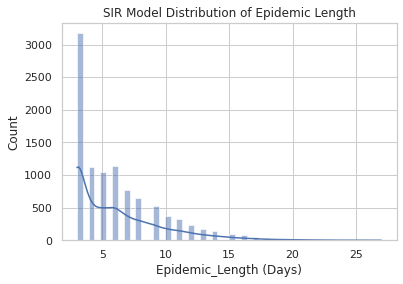

In [45]:
sns.histplot(data = df, x = "Epidemic_Length (Days)", kde = True)
plt.title('SIR Model Distribution of Epidemic Length')

Text(0.5, 1.0, 'SIR Model Distribution of Infection Totals')

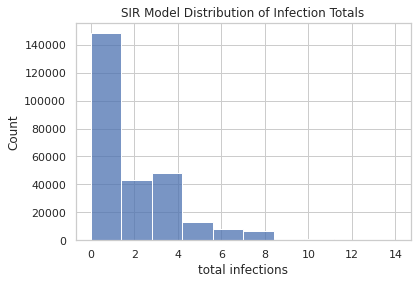

In [48]:
sns.histplot(data = long_df, x = "total infections", bins = 10)
plt.title('SIR Model Distribution of Infection Totals')

In [63]:
#TODO facet plot of infection distribution for each day

Text(0.5, 1.0, 'SIR Model Mean Daily Infections Time Series')

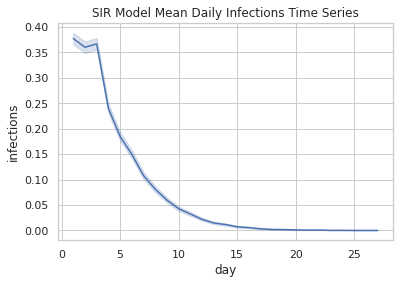

In [51]:
sns.lineplot(x = "day", y = "infections", data = long_df)
plt.title('SIR Model Mean Daily Infections Time Series')

Text(0.5, 1.0, 'SIR Model Mean Total Infections Time Series')

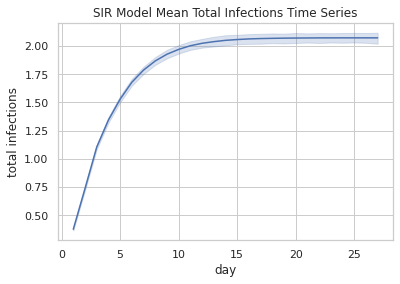

In [50]:
sns.lineplot(x = "day", y = "total infections", data = long_df)
plt.title('SIR Model Mean Total Infections Time Series')

In [39]:
sir_df = long_df.melt(id_vars=['simulation', 'day'], value_vars = ["total infections", "recovered", "suseptible"])
sir_df.head()

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,0
2,0,3,total infections,0
3,0,4,total infections,0
4,0,5,total infections,0


Text(0.5, 1.0, 'SIR Model Infections Time Series')

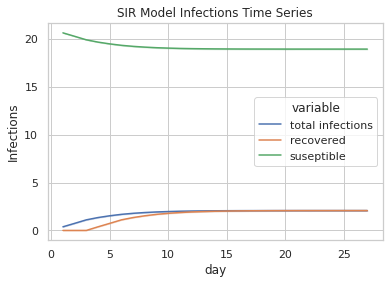

In [43]:
sns.lineplot(x = "day", y = "value", data = sir_df, hue = "variable")
plt.ylabel('Infections')
plt.title('SIR Model Infections Time Series')

### Plotting each simulation

In [21]:
less_runs = Experiment(100, 200, 0.02, 3)
df2 = less_runs.run_experiment()
long_df2 = long(df2)

Total time elapsed to gather data for 100 trials: 0:00:00.294069




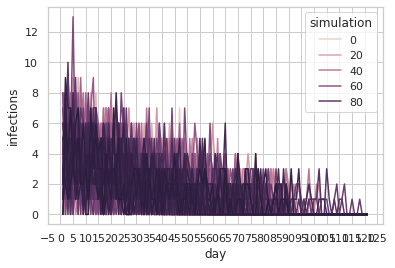

In [22]:
plt = sns.lineplot(data = long_df2, x = "day", y = "infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(5))

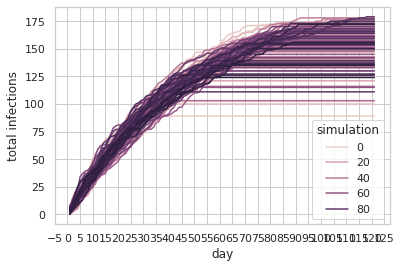

In [23]:
plt = sns.lineplot(data = long_df2 , x = "day", y = "total infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(5))

## Additional Analysis

This section includes:

*   Effect of varied infection probability
*   Effect of varied infection length
*   Effect of varied class size




### Varied Infection probability
n = 21, infection length = 3 days

In [52]:
infection_probs = [.01, .02, .03, .04, .05]
prob_dfs = {}
epi_len = pd.DataFrame()
n = 1
for p in infection_probs:
  df = Experiment(10000, 21, p, 3).run_experiment()
  epi_len[str(p)] = df[["Epidemic_Length (Days)"]]
  prob_dfs[n] = long(df)
  n +=1

epi_len.reset_index(inplace=True)
epi_len = epi_len.rename(columns = {'index':'simulation'})
epi_len = epi_len.melt(id_vars=['simulation'], var_name = "infection probability", value_name = "length of epidemic")

Total time elapsed to gather data for 10000 trials: 0:00:01.557961


Total time elapsed to gather data for 10000 trials: 0:00:01.708779


Total time elapsed to gather data for 10000 trials: 0:00:03.593696


Total time elapsed to gather data for 10000 trials: 0:00:02.961438


Total time elapsed to gather data for 10000 trials: 0:00:03.782529




Text(0.5, 0.98, 'Effect of Infection Probability')

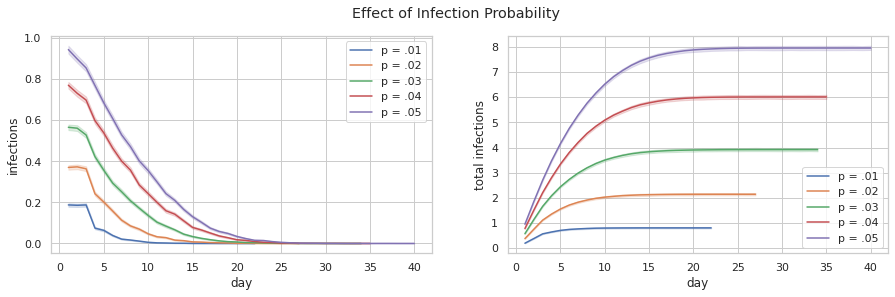

In [53]:
fig, ax = plt.subplots(1,2)
sns.lineplot(x = "day", y = "infections", data = prob_dfs[1], label ='p = .01', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = prob_dfs[2], label ='p = .02', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = prob_dfs[3], label ='p = .03', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = prob_dfs[4], label ='p = .04', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = prob_dfs[5], label ='p = .05', ax=ax[0])
sns.lineplot(x = "day", y = "total infections", data = prob_dfs[1], label ='p = .01', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = prob_dfs[2], label ='p = .02', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = prob_dfs[3], label ='p = .03', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = prob_dfs[4], label ='p = .04', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = prob_dfs[5], label ='p = .05', ax=ax[1])
fig.set_size_inches(15, 4)
fig.suptitle('Effect of Infection Probability')

Text(0.5, 0.98, 'Effect of Infection Probability on Epidemic Length')

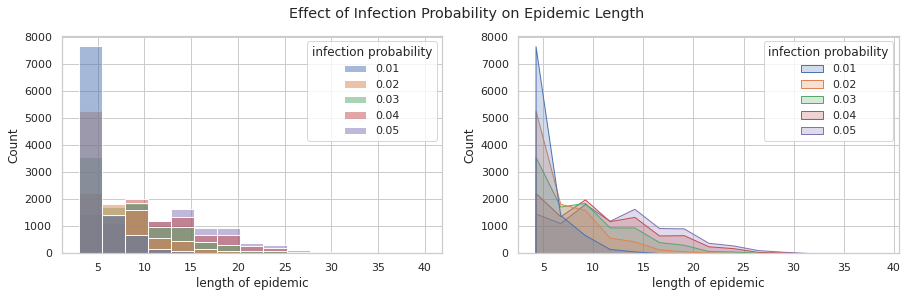

In [54]:
fig, ax = plt.subplots(1,2)
sns.histplot(data = epi_len, x = "length of epidemic", hue = "infection probability", bins = 15, ax = ax[0])
sns.histplot(data = epi_len, x = "length of epidemic", hue = "infection probability", bins = 15, element = "poly", ax = ax[1])
fig.set_size_inches(15, 4)
fig.suptitle('Effect of Infection Probability on Epidemic Length')

### Varied Infection Length

In [55]:
infection_lengths = [1,2,3,4,5]
l_dfs = {}
epi_len2 = pd.DataFrame()
n = 1
for l in infection_lengths:
  df = Experiment(10000, 21, .02, l).run_experiment()
  epi_len2[str(l)] = df[["Epidemic_Length (Days)"]]
  l_dfs[n] = long(df)
  n +=1

epi_len2.reset_index(inplace=True)
epi_len2 = epi_len2.rename(columns = {'index':'simulation'})
epi_len2 = epi_len2.melt(id_vars=['simulation'], var_name = "infection length", value_name = "length of epidemic")

Total time elapsed to gather data for 10000 trials: 0:00:00.499336


Total time elapsed to gather data for 10000 trials: 0:00:01.197997


Total time elapsed to gather data for 10000 trials: 0:00:02.047858


Total time elapsed to gather data for 10000 trials: 0:00:02.852185


Total time elapsed to gather data for 10000 trials: 0:00:03.599646




Text(0.5, 0.98, 'Effect of Infection Length')

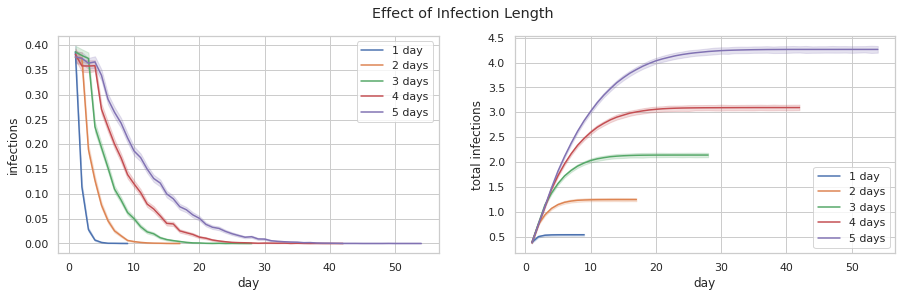

In [56]:
fig, ax = plt.subplots(1,2)
sns.lineplot(x = "day", y = "infections", data = l_dfs[1], label ='1 day', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = l_dfs[2], label ='2 days', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = l_dfs[3], label ='3 days', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = l_dfs[4], label ='4 days', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = l_dfs[5], label ='5 days', ax=ax[0])
sns.lineplot(x = "day", y = "total infections", data = l_dfs[1], label ='1 day', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = l_dfs[2], label ='2 days', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = l_dfs[3], label ='3 days', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = l_dfs[4], label ='4 days', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = l_dfs[5], label ='5 days', ax=ax[1])
fig.set_size_inches(15, 4)
fig.suptitle('Effect of Infection Length')

Text(0.5, 0.98, 'Distribution of Epidemic Lengths for Various Infection Lengths')

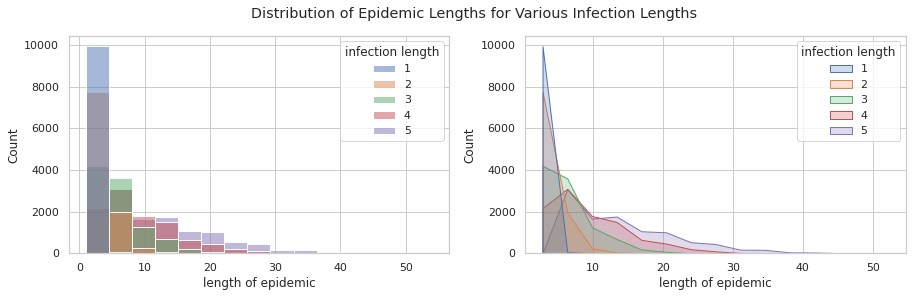

In [57]:
fig, ax =plt.subplots(1,2)
sns.histplot(data = epi_len2, x = "length of epidemic", hue = "infection length", bins = 15, ax=ax[0])
sns.histplot(data = epi_len2, x = "length of epidemic", hue = "infection length", bins = 15, element = "poly", ax=ax[1])
fig.set_size_inches(15, 4)
plt.suptitle('Distribution of Epidemic Lengths for Various Infection Lengths')

### Varied Class Size

p =.02, infection length = 3 days

In [58]:
class_size = [*range(10, 101, 10)]
c_dfs = {}
epi_len3 = pd.DataFrame()
n = 1
for c in class_size:
  df = Experiment(10000, c, .02, 3).run_experiment()
  epi_len3[str(c)] = df[["Epidemic_Length (Days)"]]
  c_dfs[n] = long(df)
  n += 1

epi_len3.reset_index(inplace=True)
epi_len3 = epi_len3.rename(columns = {'index':'simulation'})
epi_len3 = epi_len3.melt(id_vars=['simulation'], var_name = "class size", value_name = "length of epidemic")

Total time elapsed to gather data for 10000 trials: 0:00:01.383725


Total time elapsed to gather data for 10000 trials: 0:00:01.700294


Total time elapsed to gather data for 10000 trials: 0:00:03.553016


Total time elapsed to gather data for 10000 trials: 0:00:03.810081


Total time elapsed to gather data for 10000 trials: 0:00:04.828206


Total time elapsed to gather data for 10000 trials: 0:00:06.653411


Total time elapsed to gather data for 10000 trials: 0:00:07.732085


Total time elapsed to gather data for 10000 trials: 0:00:09.720488


Total time elapsed to gather data for 10000 trials: 0:00:11.001278


Total time elapsed to gather data for 10000 trials: 0:00:12.604070




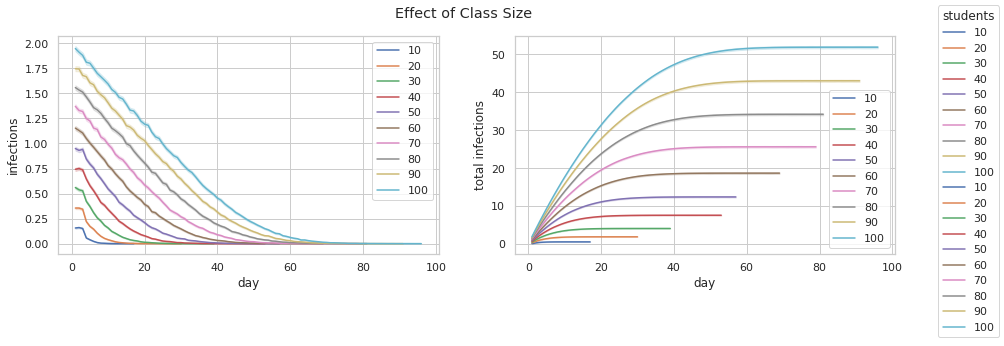

In [61]:
fig, ax = plt.subplots(1,2)
sns.lineplot(x = "day", y = "infections", data = c_dfs[1], label ='10', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[2], label ='20', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[3], label ='30', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[4], label ='40', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[5], label ='50', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[6], label ='60', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[7], label ='70', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[8], label ='80', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[9], label ='90', ax=ax[0])
sns.lineplot(x = "day", y = "infections", data = c_dfs[10], label ='100', ax=ax[0])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[1], label ='10', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[2], label ='20', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[3], label ='30', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[4], label ='40', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[5], label ='50', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[6], label ='60', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[7], label ='70', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[8], label ='80', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[9], label ='90', ax=ax[1])
sns.lineplot(x = "day", y = "total infections", data = c_dfs[10], label ='100', ax=ax[1])
fig.set_size_inches(15, 4)
fig.suptitle('Effect of Class Size')
fig.legend(title = "students")

Text(0.5, 0.98, 'Distribution of Epidemic Length for Various Class Sizes')

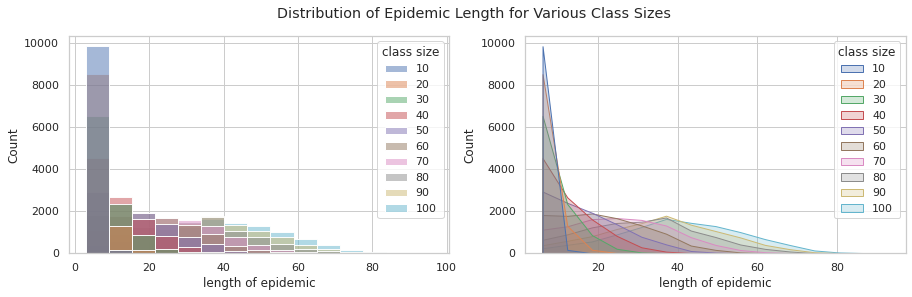

In [62]:
fig, ax =plt.subplots(1,2)
sns.histplot(data = epi_len3, x = "length of epidemic", hue = "class size", bins = 15, ax=ax[0])
sns.histplot(data = epi_len3, x = "length of epidemic", hue = "class size", bins = 15, element = "poly", ax=ax[1])
fig.set_size_inches(15, 4)
fig.suptitle('Distribution of Epidemic Length for Various Class Sizes')